<a href="https://colab.research.google.com/github/machlovi/Spock-paper/blob/main/X_hate_and_offensive_data_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect with Gdrive

In [1]:
# ! apt-get install git

# Import Libraries

In [129]:
# !ls
!cd ../

In [130]:
# !pip install transformers --quiet

!cd ../../




In [1]:
import os
import random
import pickle
from timeit import default_timer as timer
from tqdm import tqdm, trange

import re
import nltk
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download("stopwords")
from string import punctuation

import pandas as pd
pd.set_option("display.max_rows",20)
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.utils import class_weight
from sklearn.manifold import TSNE


from transformers import TFAutoModel, BertTokenizerFast, BertModel
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks as cb
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.constraints import MaxNorm
import keras
from keras.layers import Input, Concatenate, Flatten, Embedding, Dense, Dropout, LSTM
from keras.models import Model, Sequential
from keras.layers import Lambda

[nltk_data] Downloading package punkt to
[nltk_data]     /home/naseem_fordham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/naseem_fordham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/naseem_fordham/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:


#  Looking for GPU using by this kernel
              
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Specify the GPU you want to use

# import tensorflow as tf

# Check if TensorFlow is using GPU
if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("No GPU devices found. TensorFlow is using CPU.")


Default GPU Device: /device:GPU:0


#Data import

Data Source "https://github.com/t-davidson/33 ##
hate-speech-and-offensive-language/blob/master/data/readme.md"
'''hate_speech = number of CF users who judged the tweet to be hate speech.
offensive_language = number of CF users who judged the tweet to be offensive.
neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither'''



### Hate and offesive data

In [133]:
# df_data1=pd.read_csv("/gdrive/MyDrive/SPOCK/Dataset/hate-speech-and-offensive-language-master/data/labeled_data.csv")


# df_peace=df_data1[df_data1['class']==2]
# df_peace=df_peace[['class','tweet']].reset_index(drop=True)
# df_hate=df_data1[(df_data1['class']==0) | (df_data1['class']==1)]

# df_hate=df_data1[(df_data1['class']==0) | (df_data1['class']==1)]
# df_hate=df_hate[['class','tweet']].reset_index(drop=True)
# df_hate['class']=1
# df_peace['class']=0




In [19]:
# df_peace['class'].unique()

### Xhate data set
Class 1 hate, Class 0 non-hate speech

In [20]:
# @title
# # Use this part for single file
# # Define the path to your text file
# file_path = "/gdrive/MyDrive/SPOCK/Dataset/xhate-main/train/XHate999-EN-Gao-train.txt"

# # Initialize empty lists to store data
# tweets = []
# labels = []

# # Read the file line by line
# with open(file_path, 'r') as file:
#     for line in file:
#         # Split the line into text and label using the last character
#         line = line.strip()  # Remove leading/trailing whitespace
#         text = line[:-2].strip()  # Extract text (excluding the last character)
#         label = line[-1]  # Extract the label (as an integer)

#         # Append data to lists
#         tweets.append(text)
#         labels.append(label)

# # Create a DataFrame from the lists
# df = pd.DataFrame({'Text': tweets, 'Label': labels})
# df.drop(0,inplace=True)

# # Display the DataFrame
# print(df)


In [21]:
# import os
# import glob

# # Define the directory path where your text files are located
# directory_path = "/gdrive/MyDrive/SPOCK/Dataset/xhate-main/train"

# # Initialize empty lists to store data
# tweets = []
# labels = []

# # Loop through all text files in the specified directory
# for filename in glob.glob(os.path.join(directory_path, '*.txt')):
#     with open(filename, 'r') as file:

#       for line in file:
#           # Split the line into text and label using the last character
#           line = line.strip()  # Remove leading/trailing whitespace
#           text = line[:-2].strip()  # Extract text (excluding the last character)
#           label = line[-1]  # Extract the label (as an integer)

#           # Append data to lists
#           tweets.append(text)
#           labels.append(label)

# # Create a DataFrame from the lists
# df = pd.DataFrame({'tweet': tweets, 'class': labels})
# df.drop(0,inplace=True)


# df['class']=pd.to_numeric(df['class'], errors='coerce')
# df['class'].fillna(0, inplace=True)
# df['class']=df['class'].astype(int)
# df_hate2=df[df['class']==1]
# df_nonhate2=df[df['class']==0]

##Combing hatespeech and xhate data for hate/offensive class

In [4]:
def text_preprocessing(text,                                                               # text is a word string ex. 'rahul in ny'
                      punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~='ã¶``''',
                      stop_words = set(stopwords.words("english"))) -> list:

        '''
        A method to preprocess text

        '''

        for x in text.lower():
            if x in punctuations:
                text = text.replace(x,"")

        # removing words that have numbers in them
        text = re.sub(r'\w*\d\w*', '', text)
        # remove digits
        text = re.sub(r'[0-9]+', ' ', text)

        # clean the whitespaces

        text = re.sub(r'\s+', ' ', text).strip()



        # convert all text to a list

        # text = text.split(' ').  # uncomment if list required
        emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text) # no emoji

        # lowercase eth

        text = text.lower()


        # drop the stop words



        # add the tags

        return text

In [5]:
# df_hate_combine=pd.concat([df_hate,df_hate2]).reset_index(drop=True)
# df_nonhat_combine=pd.concat([df_peace,df_nonhate2]).reset_index(drop=True)

In [6]:
# df_hate_combine["tweet"] = df_hate_combine["tweet"].apply(lambda x : text_preprocessing(x))
# df_nonhat_combine["tweet"] = df_nonhat_combine["tweet"].apply(lambda x : text_preprocessing(x))

In [7]:
# dataframe=pd.concat([df_hate_combine ,df_nonhat_combine]).reset_index(drop=True)
# dataframe.dropna(inplace=True)


In [8]:
!pwd

/home/naseem_fordham/Spock-paper


In [9]:
dataframe=pd.read_csv("/home/naseem_fordham/Spock-paper/combine_data.csv")
dataframe.dropna(inplace=True)


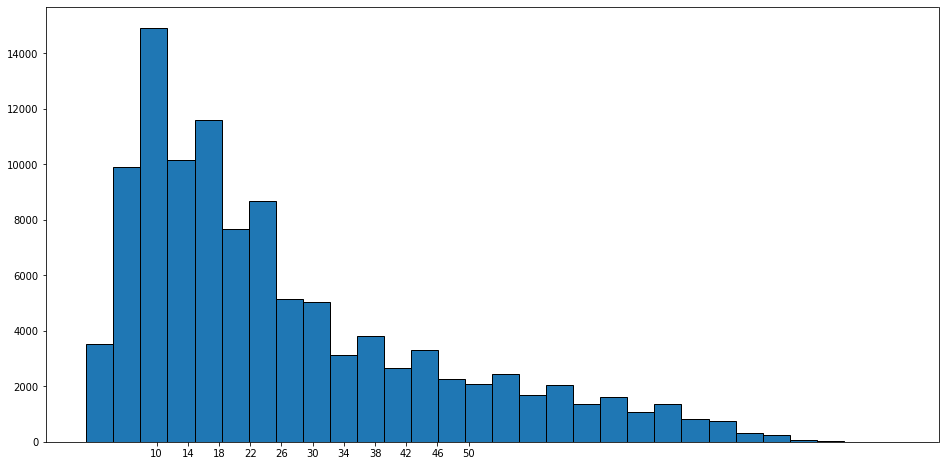

In [10]:
# token lengths distribution in the dataset
token_lengths = [len(i.split()) for i in dataframe["tweet"]]
plt.figure(figsize=(16,8))
plt.hist(token_lengths,bins = 30,edgecolor="black")
plt.xticks(ticks = np.linspace(10,50,11))
plt.show()

In [11]:
# dataframe[dataframe['class']==1].shape,dataframe[dataframe['class']==0].shape,dataframe[dataframe['class']==2].shape

# Training and validation set
We can also consider token length

In [12]:
# token_length 128, seems a good fit for data

# split training and validation data
train_df, temp_df = train_test_split(dataframe, test_size= 0.30, stratify= dataframe["class"], random_state = 47)

val_df,   test_df   = train_test_split(temp_df, test_size= 0.50, stratify= temp_df["class"],random_state = 47)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop  = True)
test_df  = test_df.reset_index(drop = True)

In [13]:
dataframe["token_length"] = token_lengths
dataframe = dataframe.loc[dataframe["token_length"] <= 45, :].reset_index(drop=True)

#Bert Model

In [14]:
# load bertModel, bertTokenizer and freeze all layers
bertModel = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
bertModel.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [15]:
# dataset generator (for input to tf.data.Dataset.from_generator())

class dataset:

  def __init__(self,text,labels,max_length, tokenizer,projection_dim, val = False):

    self.text =   text
    self.labels = labels
    self.max_length = max_length
    self.tokenizer = tokenizer
    self.flag = val
    self.projection_dim = projection_dim

  def __len__(self):

    return  self.text.shape[0]

  def __getitem__(self,index):

    sentence = self.text[index]
    category = self.labels[index]

    return sentence, category


  # shuffle the dataset after each epoch
  def on_epoch_end(self):

    random_idx = random.sample(list(range(self.__len__())), k = self.__len__())
    self.text   = self.text[random_idx]
    self.labels = self.labels[random_idx]

  def __call__(self):

    for i in range(self.__len__()):
      sentence, label = self.__getitem__(i)
      encodings = self.tokenizer(sentence,
                                 max_length = self.max_length,
                                 padding = "max_length",
                                 truncation = True)

      input_ids  = np.array(encodings["input_ids"])
      masks      = np.array(encodings["attention_mask"])
      ttids      = np.array(encodings["token_type_ids"])

      embedding_index = np.array([i for i in range(self.projection_dim)])
      embedding_index = np.ravel(embedding_index)

      embedding_index = np.tile(embedding_index, (input_ids[0:1].shape[0],))

      yield {"input_ids": input_ids, "attention_masks": masks,"space": embedding_index}, label

      # randomize the dataset on epoch end, only in case of training dataset
      if i == self.__len__() -1 and self.flag is False:
        self.on_epoch_end()

In [16]:
dataframe[dataframe['class']==1].count(),dataframe[dataframe['class']==0].count()


(class           33357
 tweet           33357
 token_length    33357
 dtype: int64,
 class           55410
 tweet           55410
 token_length    55410
 dtype: int64)

# Paramters

In [17]:
MAX_LENGTH = 45
BATCH_SIZE = 32
# PROJECTION_DIM = 10
VECTOR_DIM = 768

In [18]:
with open('/home/naseem_fordham/Spock-paper/nweights.npy', 'rb') as f:
    hate_weights = np.load(f,allow_pickle=True)
hate_weights=np.reshape(hate_weights,[1,np.shape(hate_weights)[0],np.shape(hate_weights)[1]])
hate_weights=hate_weights[:,:10,:]
PROJECTION_DIM=hate_weights.shape[1]
PROJECTION_DIM,hate_weights.shape

(10, (1, 10, 768))

In [19]:
# create generators for train and validation
train_gen = dataset(train_df["tweet"].values,train_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer,projection_dim=PROJECTION_DIM)
val_gen   = dataset(val_df["tweet"].values,val_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)

In [20]:
train_gen[1000]

('to provide clarification what is your professional designation and scientific credentilals',
 0)

In [21]:
# create tensorflow dataloaders from generators

train_ds = tf.data.Dataset.from_generator(train_gen,
                                            output_signature =
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).repeat().batch(batch_size = BATCH_SIZE) # shuffling is already implemented in dataset class

val_ds = tf.data.Dataset.from_generator(val_gen,
                                            output_signature =
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [22]:
## AUXILLIARY FUNCTIONS
for ele in train_ds.take(1):
    t=ele

Loading Weights

In [23]:
with open('nweights.npy', 'rb') as f:
    hate_weights = np.load(f,allow_pickle=True)
hate_weights=np.reshape(hate_weights,[1,np.shape(hate_weights)[0],np.shape(hate_weights)[1]])
hate_weights=hate_weights[:,:10,:]
PROJECTION_DIM=hate_weights.shape[1]
PROJECTION_DIM
# hate_weights.shape

10

In [24]:
hate_weights[:,:10,:].shape

(1, 10, 768)

# Model Architecture

In [200]:


def mean_pooling(vects):
    model_output, attention_mask=vects[0], vects[1]
    # token_embeddings = model_output  # Assuming model_output contains all token embeddings
    input_mask_expanded = tf.expand_dims(attention_mask, axis=-1)
    # input_mask_expanded = tf.cast(input_mask_expanded, dtype=tf.float32)
    
    input_mask_expanded = tf.cast(tf.reshape(input_mask_expanded, shape=(45, 768)), dtype=tf.float32)


    # print(model_output.shape,attention_mask.shape,input_mask_expanded.shape)
    
    result = tf.reduce_sum(model_output * input_mask_expanded, axis=1) / tf.maximum(tf.reduce_sum(input_mask_expanded, axis=1), 1e-9)
    print(result.shape)
    
    # result = Reshape((None,45))(result)

    return  result
# Example usage:
# peace_sentence_embeddings = mean_pooling(peace_outputs, peace_encoded['attention_mask'])


In [205]:


def mean_pooling(vects):
    model_output, attention_mask=vects[0], vects[1]
    # token_embeddings = model_output  # Assuming model_output contains all token embeddings
    input_mask_expanded = tf.expand_dims(attention_mask, axis=-1)
    # input_mask_expanded = tf.cast(input_mask_expanded, dtype=tf.float32)
    
    input_mask_expanded = tf.cast(tf.reshape(input_mask_expanded, shape=(45, 768)), dtype=tf.float32)


    # print(model_output.shape,attention_mask.shape,input_mask_expanded.shape)
    
    result = tf.reduce_sum(model_output * input_mask_expanded, axis=1) / tf.maximum(tf.reduce_sum(input_mask_expanded, axis=1), 1e-9)
    print(result.shape)
    
    # result = Reshape((None,45))(result)

    return  result
# Example usage:


# Model Debugging - Rahul
from tensorflow.keras.layers import Lambda, Reshape
from tensorflow.keras.layers import Input, Permute


DEBUG = "DEBUG"
PROJECTION_DIM=10
# for input we have
# 1. input ids
# 2. attention_masks
# 3. embedding_index (PROJECTION_DIM)
# 4. label

# first two will go to bert as input
ids = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "input_ids")
mks = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "attention_masks")
projection_space = layers.Input(name = "space", shape = (PROJECTION_DIM,))


input_sentence = bertModel(ids, attention_mask = mks)[0]                   # layers freezed, last_hidden_state_output

# print(input_sentence.shape)
# CLASSIFICATION HEAD

# hidden = layers.Dense(612, activation='relu', name = "hidden-1", kernel_constraint=MaxNorm(3),
#                kernel_initializer = "he_normal")(merged)


sen_emb = layers.Lambda(function=mean_pooling,
                name='sentence-embedding')(input_sentence)  # (None,1,1002)    # !these values are not really identical beacause both embedding layers had different random weights

sen_emb_reshaped = layers.Permute((None, 45), input_shape(None,MAX_LENGTH)(sen_emb)
  
                        
                                  

# input_sentence =keras.layers.Input( shape=(768),name = "sentence")    # (None,64,768)


    # reshaped_tensor = tf.reshape(input_tensor, (1, 45))


print('sentence-embedding')
print(sen_emb_reshaped.shape)



hidden = layers.Dense(256, activation='relu', name = "hidden-1", kernel_constraint=MaxNorm(3),
               kernel_initializer = "he_normal")(sen_emb)

hidden = layers.Dropout(0.65, name="drop-1")(hidden)
hidden = layers.Dense(64, activation='relu', name = "hidden-2", kernel_constraint=MaxNorm(3),
               kernel_initializer = "he_normal")(hidden)
hidden = layers.Dropout(0.65, name="drop-2")(hidden)
hidden = layers.Dense(16, activation='relu', name = "hidden-3", kernel_constraint=MaxNorm(3),
               kernel_initializer= "he_normal")(hidden)
hidden = layers.Dropout(0.25, name="drop-3")(hidden)


predictions = layers.Dense(1, activation= "sigmoid" , name='classification_layer')(hidden)

model = Model(inputs=[ids, mks, projection_space],outputs= predictions)

(45,)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-205-9885e1fa71d5>:52 in <module>                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: __init__() takes 2 positional arguments but 3 were given

In [ ]:
model.summary()


Loss Function

In [152]:
# cross entropy loss
crossEntropLoss = tf.keras.losses.BinaryCrossentropy(from_logits = False)


# optimize can compile
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, clipnorm = 1.0)
model.compile(loss = crossEntropLoss , optimizer = optimizer, metrics=["accuracy"])

In [153]:
# mini batches per epoch
len(train_gen) // BATCH_SIZE

2358

In [154]:
# BASE_PATH = "/gdrive/Shareddrives/Thesis/"
BASE_PATH = "/home/naseem_fordham/Spock-paper/Base_model"


In [155]:
# uncomment while training:

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= BASE_PATH + "baseline.h5",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "auto",
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True)

In [156]:
len(train_gen) // BATCH_SIZE

2358

In [157]:
EPOCHS = 2
history = model.fit(
    train_ds,
    steps_per_epoch = len(train_gen) // BATCH_SIZE,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = [modelcheckpoint]
)

Epoch 1/2
(45,)
(45,)
1025/2358 [============>.................] - ETA: 57s - loss: 19823443968.0000 - accuracy: 0.5066

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-157-af189a46c707>:2 in <module>                                                   │
│                                                                                                  │
│ /home/naseem_fordham/.local/lib/python3.8/site-packages/keras/engine/training.py:1184 in fit     │
│                                                                                                  │
│   1181 │   │   │   │   batch_size=batch_size,                                                    │
│   1182 │   │   │   │   _r=1):                                                                    │
│   1183 │   │   │     callbacks.on_train_batch_begin(step)                                        │
│ ❱ 1184 │   │   │     tmp_logs = self.train_function(iterator)                                    │
│   1185 │   │   │     if data_handler.should_sync:                                                │
│   1186 │   │   │   │   context.async_wait()                                                      │
│   1187 │   │   │     logs = tmp_logs  # No error, now safe to assign to logs.                    │
│                                                                                                  │
│ /usr/lib/python3/dist-packages/tensorflow/python/util/traceback_utils.py:150 in error_handler    │
│                                                                                                  │
│   147 │                                                                                          │
│   148 │   filtered_tb = None                                                                     │
│   149 │   try:                                                                                   │
│ ❱ 150 │     return fn(*args, **kwargs)                                                           │
│   151 │   except Exception as e:                                                                 │
│   152 │     filtered_tb = _process_traceback_frames(e.__traceback__)                             │
│   153 │     raise e.with_traceback(filtered_tb) from None                                        │
│                                                                                                  │
│ /usr/lib/python3/dist-packages/tensorflow/python/eager/def_function.py:915 in __call__           │
│                                                                                                  │
│    912 │     compiler = "xla" if self._jit_compile else "nonXla"                                 │
│    913 │                                                                                         │
│    914 │     with OptionalXlaContext(self._jit_compile):                                         │
│ ❱  915 │   │   result = self._call(*args, **kwds)                                                │
│    916 │                                                                                         │
│    917 │     new_tracing_count = self.experimental_get_tracing_count()                           │
│    918 │     without_tracing = (tracing_count == new_tracing_count)                              │
│                                                                                                  │
│ /usr/lib/python3/dist-packages/tensorflow/python/eager/def_function.py:947 in _call              │
│                                                                                                  │
│    944 │     self._lock.release()                                                                │
│    945 │     # In this case we have created variables on the first call, so we run the           │
│    946 │     # defunned version which is guaranteed to never create variables.                   │
│ ❱  947 │     return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable            │
│    948 │   elif self._stateful_fn is not None:             

# Model Save 

In [93]:
BASE_PATH

'/home/naseem_fordham/Spock-paper/Base_model'

In [94]:
# UNCOMMENT THIS CELL AFTER MODEL TRAINING

# save model history

with open(f"{BASE_PATH}/base_line_training_historyV4.pkl","wb") as hist:
  pickle.dump(history.history,hist)

# history=np.save(f"/home/naseem_fordham/Hate_Xplain/history/C_loss_history_{PROJECTION_DIM}.npy",history.histor

# Load Weights and Model Evaluation

In [95]:
# BASE_PATH='/home/naseem_fordham/Spock-paper/'
model.load_weights(f"{BASE_PATH}/Modelbaseline.h5")
history=np.load(f"{BASE_PATH}/base_line_training_historyV4.pkl",allow_pickle=True)
history


{'loss': [0.5420613884925842, 0.472851425409317],
 'accuracy': [0.7157548666000366, 0.775233268737793],
 'val_loss': [0.462263286113739, 0.46857813000679016],
 'val_accuracy': [0.853670597076416, 0.8565773963928223]}

In [96]:
# prepare test data for evaluation:
test_gen   = dataset(test_df["tweet"].values,test_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)
test_ds = tf.data.Dataset.from_generator(test_gen,
                                            output_signature = 
                                           ({"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [97]:
# convert sigmoid outputs to labels
def predictionLabels(i):

  if i < 0.5:
    return 0.0
  else:
    return 1.0

getLabels = np.vectorize(predictionLabels)
predictions = model.predict(test_ds)
predictedLabels = getLabels(predictions)

In [98]:
predictions = model.predict(test_ds)
predictedLabels = getLabels(predictions)

In [99]:
predictedLabels.shape

(16170, 45, 1)

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
predictedLabels = getLabels(predictions)

confusion_matrix(test_df['class'].values, predictedLabels)
ConfusionMatrixDisplay.from_predictions(test_df['class'].values, predictedLabels)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-100-46652bd45f97>:4 in <module>                                                   │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:317 in                 │
│ confusion_matrix                                                                                 │
│                                                                                                  │
│    314 │   >>> (tn, fp, fn, tp)                                                                  │
│    315 │   (0, 2, 1, 1)                                                                          │
│    316 │   """                                                                                   │
│ ❱  317 │   y_type, y_true, y_pred = _check_targets(y_true, y_pred)                               │
│    318 │   if y_type not in ("binary", "multiclass"):                                            │
│    319 │   │   raise ValueError("%s is not supported" % y_type)                                  │
│    320                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:95 in _check_targets   │
│                                                                                                  │
│     92 │   │   y_type = {"multiclass"}                                                           │
│     93 │                                                                                         │
│     94 │   if len(y_type) > 1:                                                                   │
│ ❱   95 │   │   raise ValueError(                                                                 │
│     96 │   │   │   "Classification metrics can't handle a mix of {0} and {1} targets".format(    │
│     97 │   │   │   │   type_true, type_pred                                                      │
│     98 │   │   │   )                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Classification metrics can't handle a mix of binary and unknown targets

In [ ]:
import seaborn as sns
# print(classification_report(y_test, predictedLabels))
clf_report = classification_report(test_df['class'],
                                   predictedLabels,
                                   
                                   target_names=[0,1],
                                   output_dict=True)


sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)


<ipython-input-60-8fc41e6f3f32>:8: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0,1,0.1)
<ipython-input-60-8fc41e6f3f32>:28: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0,3,0.1)


Text(0.5, 1.0, 'Training vs Validation loss')

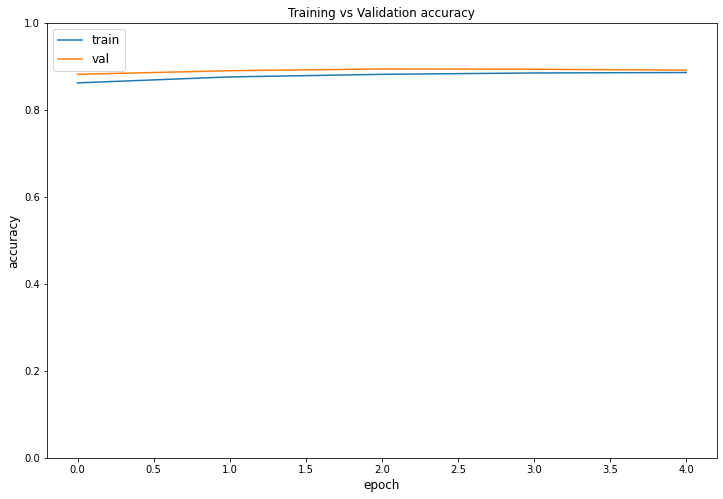

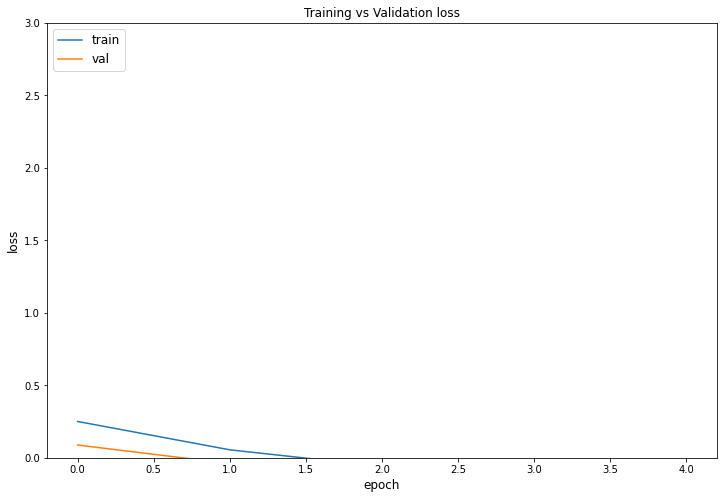

In [60]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy',fontdict = {'fontsize' : 12})
plt.ylim(0,1,0.1)

plt.ylabel('accuracy',fontdict = {'fontsize' : 12})
plt.xlabel('epoch',{'fontsize' : 12})
# plt.ylim(0, ,0.05)
plt.legend(['train', 'val'], loc='upper left',fontsize=12)
plt.title('Training vs Validation accuracy')
# display(plt.show())
# plt.show()

# plt.savefig(f"/home/naseem_fordham/Hate_Xplain//acc.png",dpi=300)
plt.savefig(f"/home/naseem_fordham/Hate_Xplain/Plots/plots{PROJECTION_DIM}/accu_{PROJECTION_DIM}.png",dpi=300)

#skip: plt.savefig("/gdrive/Shareddrives/Thesis/Results_for_thesis/spock_xhate_acc.png",dpi=300)

plt.figure(figsize=(12,8))
# plt.yticks(np.arange(0,1,step=.1))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0,3,0.1)

# plt.title('Training loss vs Validation Loss',fontdict = {'fontsize' : 12})
plt.ylabel('loss',fontdict = {'fontsize' : 12})
plt.xlabel('epoch',fontdict = {'fontsize' : 12})
plt.legend(['train', 'val'], loc='upper left',fontsize=12)
plt.title('Training vs Validation loss')

# Lime Explainibity
In this part we are using LIME method to understnd how our model is predicting each word in the senetcen and labeled it as per classification## In this part we are using LIME method to understnd how our model is predicting each word in the senetcen and labeled it as per classification

In [62]:
# for ele in train_ds.take(1):
#   temp = ele
# temp_iids = temp[0]["input_ids"]
# # temp_mask = temp[0]["attention_masks"]
# temp_iids

In [39]:
# laoding data set and performning cleaning to ready for feed funtion,
# here we have assigned a tem class to our data set
df_test=pd.read_csv('/home/naseem_fordham/Spock-paper/test.txt',sep='/n', header=None,engine='python')
df_test = df_test.rename(columns={0: 'tweet'})
df_test

df_test["tweet"] = df_test["tweet"].apply(lambda x : text_preprocessing(x))
df_test['class']=1
df_test


,tweet,class
0,we hate niggers we hate faggots and we hate spics,1
1,lmfaoooo i hate black people”,1
2,i likes dat name dem sand niggers needs to kno...,1
3,keep doing your thing kid people why soon real...,1
4,vp joe the dildo still wants your guns hey joe...,1
5,when u hitting it from the back u gotta call h...,1
6,lot of rain too bad it wasnt enough to wash aw...,1
7,jihadi rehab needs to account for the unpleasa...,1
8,these sour apple bitter bitches im not fuckin ...,1
9,these jews are again using holohax as an execu...,1


In [40]:
# create generators for train and validation
BATCH_SIZE = 32
# make sure batch size complies with total data set
lime_gen = dataset(df_test["tweet"].values,df_test["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer,projection_dim=PROJECTION_DIM)

# create tensorflow dataloaders from generators
lime_ds = tf.data.Dataset.from_generator(lime_gen,
                                            output_signature =
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [41]:
# Predict function which will be use later for each text in sentence
def predict_fun(x):
    return np.array([[float(1-x), float (x)] for x in model.predict(lime_ds)])

In [42]:
# for ele in lime_ds.take(1):
#     t=ele


In [43]:
# from lime.lime_text import LimeTextExplainer

# x=df_test['tweet'][0]
# print(len(x))


# explainer = LimeTextExplainer(class_names=['non_hate','hate'])
# exp=explainer.explain_instance(x, predict_fun, num_features=90, labels=(1,), num_samples=9, distance_metric='cosine')
# exp.show_in_notebook(text=True)

In [44]:
# Implementing LIME on each sentence
"""Interpretability: If you want highly interpretable explanations that focus on the most salient 
words or terms, you may choose a lower num_features value.

Comprehensiveness: If you want a more comprehensive understanding of why the model made a particular
prediction and are willing to explore a larger number of words or terms, you may choose a higher num_features value."""

from lime.lime_text import LimeTextExplainer
for i in range(8,10):

    x=df_test['tweet'].iloc[i]

    explainer = LimeTextExplainer(class_names=['non_hate','hate'])
    exp=explainer.explain_instance(x, predict_fun, num_features=25, labels=(1,), num_samples=10, distance_metric='cosine')
    exp.show_in_notebook(text=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-44-7a55fed0761c>:14 in <module>                                                   │
│                                                                                                  │
│ /home/naseem_fordham/.local/lib/python3.8/site-packages/lime/lime_text.py:413 in                 │
│ explain_instance                                                                                 │
│                                                                                                  │
│   410 │   │   │   │   │   │   │   │   │   │   split_expression=self.split_expression,            │
│   411 │   │   │   │   │   │   │   │   │   │   mask_string=self.mask_string))                     │
│   412 │   │   domain_mapper = TextDomainMapper(indexed_string)                                   │
│ ❱ 413 │   │   data, yss, distances = self.__data_labels_distances(                               │
│   414 │   │   │   indexed_string, classifier_fn, num_samples,                                    │
│   415 │   │   │   distance_metric=distance_metric)                                               │
│   416 │   │   if self.class_names is None:                                                       │
│                                                                                                  │
│ /home/naseem_fordham/.local/lib/python3.8/site-packages/lime/lime_text.py:482 in                 │
│ __data_labels_distances                                                                          │
│                                                                                                  │
│   479 │   │   │   │   │   │   │   │   │   │   │   │   replace=False)                             │
│   480 │   │   │   data[i, inactive] = 0                                                          │
│   481 │   │   │   inverse_data.append(indexed_string.inverse_removing(inactive))                 │
│ ❱ 482 │   │   labels = classifier_fn(inverse_data)                                               │
│   483 │   │   distances = distance_fn(sp.sparse.csr_matrix(data))                                │
│   484 │   │   return data, labels, distances                                                     │
│   485                                                                                            │
│ <ipython-input-41-e1a8d3ea5c81>:3 in predict_fun                                                 │
│ <ipython-input-41-e1a8d3ea5c81>:3 in <listcomp>                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: only size-1 arrays can be converted to Python scalars

# Lime EXplaniation Alternative method

In [360]:
# for ele in lime_ds.take(0):
#   temp = ele
# temp_iids = temp[0]
# # # temp_mask = temp[0]["attention_masks"]
# temp_iids

In [361]:
# test_res= list()
# for tweet in df_test['tweet']:
#   tweet = text_preprocessing(tweet)
#   test_res.append(tweet)
#     # print(tweet)

# df_test['tweet'].tolist()

In [362]:
# # Input_ids=Inputs_test.reshape((Inputs_test.shape[0],1,Inputs_test.shape[1]))
# # bertModel = TFAutoModel.from_pretrained("bert-base-uncased")
# # tokenizer 
# '''In this part we are creating the bert inputs for our model and pass it to the model to predicts the class. 
# Later on we pass this predict model to LIME to underrstand which part of text is more relavent as per our model prediction'''

# from transformers import BertTokenizer, BertModel

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bmodel = BertModel.from_pretrained("bert-base-uncased")

# import torch
# def predict(x):
#     encoded = tokenizer(
#     text=df_test['tweet'].tolist(),  # the sentence to be encoded
#     add_special_tokens=True,  # Add [CLS] and [SEP]
#     max_length = 45,  # maximum length of a sentence
#     padding='max_length',  # Add [PAD]s
#     return_attention_mask = True,  # Generate the attention mask
#     return_tensors = 'pt',  # ask the function to return PyTorch tensors

#   )
#   # print(encoded)
#     with torch.no_grad():

#         outputs = bmodel(**encoded)

#         # Evaluating the model will return a different number of objects based on 
#         # how it's  configured in the `from_pretrained` call earlier. In this case, 
#         # becase we set `output_hidden_states = True`, the third item will be the 
#         # hidden states from all layers. See the documentation for more details:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
#         # hidden_states = outputs[2]
#         # violent_hidden_states = violent_outputs[2]

#         last_hidden_states = outputs.last_hidden_state

#     # print(last_hidden_states)

#     x_test=last_hidden_states.numpy()
#     # print(x_test.shape)
#     Inputs_test=encoded['input_ids']
#     # print(Inputs_test.shape)
#     Inputs_test=Inputs_test.reshape((Inputs_test.shape[0],1,Inputs_test.shape[1])).numpy()
#     print(Inputs_test.shape)


#     # print(x_test.shape,Inputs_test.shape)
#     embedding_test=embedding_index[0].reshape(embedding_index[0].shape[0],1)
#     # embedding_test=embedding_index[:30]
#   # embedding_test=embedding_index[:30].reshape(30,embedding_index[:30].shape[1],1)
#   # embedding_test=embedding_index[:10].reshape(10,embedding_index.shape[1])
#   # return model.predict([x_test,Inputs_test,embedding_test])
  
#     # print(embedding_test.shape)
#     print(x_test.shape,Inputs_test.shape,embedding_test.shape)
#     return np.array([[float(1-x), float (x)] for x in model.predict(lime_ds)])
#     # return last_hidden_states
# # model.predict([x_train,Input_ids,embedding_index])

In [340]:
# def return_embedding_index(count):
  
#   embedding_index=np.array([i for i in range(count)])
#   # embeding_index=np.array([[0,1,2]])
#   embeding_index=np.ravel(embedding_index)

#   embedding_index=np.tile(embedding_index,(len(df_test),1,))
#   # print(embedding_index.shape, type(embeding_index))
#   return embedding_index

# embedding_index = return_embedding_index(PROJECTION_DIM)
# embedding_index.shape

(9, 10)

In [358]:
# from lime.lime_text import LimeTextExplainer

# x=df_test['tweet'][0]
# print(len(x))


# explainer = LimeTextExplainer(class_names=['peace','offensive'])
# exp=explainer.explain_instance(x, predict, num_features=60, labels=(1,), num_samples=9, distance_metric='cosine')
# #num of sample must be same as length of the data set 
# exp.show_in_notebook(text=True)

In [359]:
# from lime.lime_text import LimeTextExplainer
# for i in range(10):

#     x=df_test['tweet'].iloc[i]

#     explainer = LimeTextExplainer(class_names=['peace','offensive'])
#     exp=explainer.explain_instance(x, predict, num_features=30, labels=(1,), num_samples=9, distance_metric='cosine')
#     #num of sample must be same as length of the data set 
#     exp.show_in_notebook(text=True)

# Model Concept Space

In [31]:
f"{BASE_PATH}/Modeltest1.h5"

'/home/naseem_fordham/Spock-paper/Model/Modeltest1.h5'

In [32]:
# model.load_weights(f"{BASE_PATH}/Modeltest1.h5")
# positive_embedding = model.get_layer('positive_embedding')  # Replace with the name of your layer
# Get the weights of the specific layer
# positive_embedding = specific_layer.get_weights()


In [414]:
# # loaded_model = model.load_weights(f"{BASE_PATH}/Modeltest1.h5")
# negative_embedding = model.get_layer('negative_embedding')  # Replace with the name of your layer
# # Get the weights of the specific layer
# negative_embedding = specific_layer.get_weights()

In [33]:
BASE_PATH

'/home/naseem_fordham/Spock-paper/Model'

In [34]:
import numpy as np
from keras.models import load_model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


model.load_weights(f"{BASE_PATH}/Modeltest1.h5")
positive_layer = model.get_layer('positive_embedding')
positive_embedding = positive_layer.get_weights()
# positive_weights=positive_weights[0].T


negative_layer = model.get_layer('negative_embedding')
negative_embedding = negative_layer.get_weights()


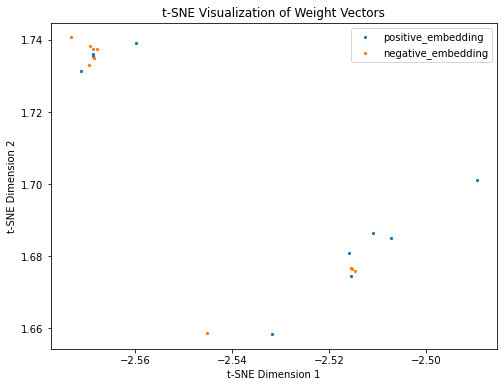

In [36]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have two weight vectors of shape (10, 768)



# Combine the two weight vectors into one array
combined_weight_vectors = np.vstack([positive_embedding[0], negative_embedding[0]])
tsne = TSNE(n_components=2, perplexity=19, early_exaggeration=12.0, learning_rate=20.0, n_iter=1000)
# Compute t-SNE embeddings
# tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(combined_weight_vectors)

# Separate the t-SNE embeddings for the two weight vectors
tsne_embeddings1 = tsne_embeddings[:10]  # First weight vector
tsne_embeddings2 = tsne_embeddings[10:]  # Second weight vector

# Create a scatter plot for the t-SNE embeddings
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings1[:, 0], tsne_embeddings1[:, 1], label='positive_embedding', s=5)
plt.scatter(tsne_embeddings2[:, 0], tsne_embeddings2[:, 1], label='negative_embedding', s=5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.title('t-SNE Visualization of Weight Vectors')
plt.show()
